In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon-music-reviews/Musical_Instruments_5.json
/kaggle/input/amazon-music-reviews/Musical_instruments_reviews.csv


In [2]:
# Importing necessary paackages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
seed = 4353

In [3]:
data = pd.read_csv('/kaggle/input/amazon-music-reviews/Musical_instruments_reviews.csv')
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
data.columns = data.columns.str.lower()
data.columns

Index(['reviewerid', 'asin', 'reviewername', 'helpful', 'reviewtext',
       'overall', 'summary', 'unixreviewtime', 'reviewtime'],
      dtype='object')

In [5]:
data.isnull().sum()

reviewerid         0
asin               0
reviewername      27
helpful            0
reviewtext         7
overall            0
summary            0
unixreviewtime     0
reviewtime         0
dtype: int64

In [6]:
print('The train dataset contans {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The train dataset contans 10261 rows and 9 columns


Text(0.5, 0, 'Overall ratings')

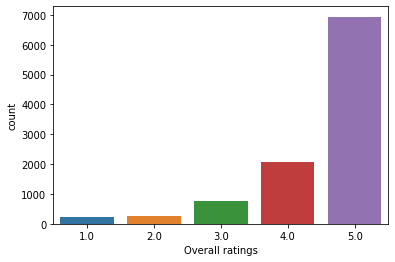

In [7]:
sns.countplot(data.overall)
plt.xlabel('Overall ratings')

In [8]:
# replacing numerical values with categorical values to reduce the classes to sentiments

data['sentiment'] = data.overall.replace({
    1:'negative',
    2:'negative',
    3:'neutral',
    4:'positive',
    5:'positive'
})

In [9]:
#Creating Train and Test datasets with only the product reviews (complete Review = reviewtext + summary)

X_data = data['reviewtext'] + ' ' + data['summary']
y_data = data['sentiment']

In [10]:
# changing the datatype from object to string

X_data = X_data.astype(str)

In [11]:
# creating new dataframe

X_data_df = pd.DataFrame(data=X_data)
X_data_df.columns = ['review']
X_data_df.head()

,review
0,"Not much to write about here, but it does exac..."
1,The product does exactly as it should and is q...
2,The primary job of this device is to block the...
3,Nice windscreen protects my MXL mic and preven...
4,This pop filter is great. It looks and perform...


In [12]:
# creating functions for text processing

string.punctuation
def final(X_data_full):
    
    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full[i])
        X_data_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2
    
    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full[i])
        X_data_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words
    
    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full[i])
        X_data_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words
    
    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full[i])
        X_data_full_lemmatized_words.append(test_data)
        
    # creating the bag of words model
    cv = CountVectorizer(max_features=1000)
    X_data_full_vector = cv.fit_transform(X_data_full_lemmatized_words).toarray()
    
    
    tfidf = TfidfTransformer()
    X_data_full_tfidf = tfidf.fit_transform(X_data_full_vector).toarray()
    
    return X_data_full_tfidf
    

In [13]:
# running the function

data_X = final(X_data)
X_train, X_test, y_train, y_test = train_test_split(data_X, y_data, test_size=0.25, random_state= seed)

## Model Selection

### Multinomial Naive Bayes

In [14]:
# Instatiation, fitting and prediction

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predictions = MNB.predict(X_test)

In [15]:
# Model evaluation

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

MNB_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, predictions)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       122
     neutral       0.00      0.00      0.00       208
    positive       0.87      1.00      0.93      2236

    accuracy                           0.87      2566
   macro avg       0.29      0.33      0.31      2566
weighted avg       0.76      0.87      0.81      2566

[[   0    0  122]
 [   0    0  208]
 [   0    0 2236]]
Accuracy :  87.14  %
f1_score :  0.812


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **XGBoost**

In [16]:
# Instatiation, fitting and predictions

xgb_ = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed= seed)

xgb_.fit(X_train, y_train)
predictions = xgb_.predict(X_test)

In [17]:
# Model evaluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

xgb_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
xgb_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , xgb_accuracy , " %")
print("f1_score : " , xgb_f1)

              precision    recall  f1-score   support

    negative       0.54      0.11      0.18       122
     neutral       0.62      0.12      0.21       208
    positive       0.89      1.00      0.94      2236

    accuracy                           0.88      2566
   macro avg       0.68      0.41      0.44      2566
weighted avg       0.85      0.88      0.84      2566

[[  13    7  102]
 [   9   26  173]
 [   2    9 2225]]
Accuracy :  88.23  %
f1_score :  0.844


### Random Forest

In [18]:
# Instatiation, fitting and predictions

from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators= 10, random_state= seed)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [19]:
# Model evaluation

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , rfc_accuracy , " %")
print("f1_score : " , rfc_f1)

              precision    recall  f1-score   support

    negative       1.00      0.02      0.05       122
     neutral       0.45      0.02      0.05       208
    positive       0.87      1.00      0.93      2236

    accuracy                           0.87      2566
   macro avg       0.78      0.35      0.34      2566
weighted avg       0.85      0.87      0.82      2566

[[   3    2  117]
 [   0    5  203]
 [   0    4 2232]]
Accuracy :  87.3  %
f1_score :  0.818


### SVM

In [20]:
# Instatiation and fitting

from sklearn.svm import SVC
from sklearn.model_selection import KFold
svc = SVC(random_state=seed)

In [21]:
# using KFold cross validation technique
kf=  KFold(n_splits=5, random_state=seed)

# Hyperparametric tuning using grid search
param_grid = [{'kernel':['rbf'],
              'gamma':[1e-3, 1e-4],
              'C':[1, 10, 100, 1000]},
             {'kernel':['linear'],
             'C':[1, 10, 100, 1000]}]

grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=kf)
grid.fit(X_train, y_train)

print('Estimator: ', grid.best_estimator_)
print('Best params : \n', grid.best_params_)
print('Output Classes: ', grid.classes_)
print('Training Accuracy: ', grid.best_score_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Estimator:  SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=4353, shrinking=True,
    tol=0.001, verbose=False)
Best params : 
 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Output Classes:  ['negative' 'neutral' 'positive']
Training Accuracy:  0.8883690708252111


In [22]:
# predictions

predictions = grid.predict(X_test)

print(classification_report(y_test, predictions))

svc_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
svc_accuracy = round((accuracy_score(y_test, predictions)*100), 2)

print("Accuracy : " , svc_accuracy , " %")
print("f1_score : " , svc_f1)

              precision    recall  f1-score   support

    negative       0.46      0.13      0.20       122
     neutral       0.68      0.12      0.21       208
    positive       0.89      0.99      0.94      2236

    accuracy                           0.88      2566
   macro avg       0.68      0.42      0.45      2566
weighted avg       0.85      0.88      0.84      2566

Accuracy :  88.11  %
f1_score :  0.845


### LSTM 

In [23]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size=32
max_words=5000

model = Sequential()
model.add(Embedding(max_words, embedding_size, input_length=X_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(3,activation='softmax'))

print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 213,503
Trainable params: 213,503
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
# converting categorical variables in y_train to numerical variables
y_train_dummies = pd.get_dummies(y_train).values
print('Shape of Label tensor: ', y_train_dummies.shape)

Shape of Label tensor:  (7695, 3)


In [26]:
#train the model
model.fit(X_train, y_train_dummies, epochs=5, batch_size=32)
#model.sav('MusicalInstrumentReviews.h5')

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
7695/7695 [==============================] - 246s 32ms/step - loss: 0.4713 - accuracy: 0.8819
Epoch 2/5
7695/7695 [==============================] - 246s 32ms/step - loss: 0.4439 - accuracy: 0.8819
Epoch 3/5
7695/7695 [==============================] - 237s 31ms/step - loss: 0.4438 - accuracy: 0.8819
Epoch 4/5
7695/7695 [==============================] - 236s 31ms/step - loss: 0.4432 - accuracy: 0.8819
Epoch 5/5
7695/7695 [==============================] - 238s 31ms/step - loss: 0.4440 - accuracy: 0.8819


In [27]:
model.save('MusicalInstrumentReviews.h5')

In [28]:
# converting categorical variables in y_train to numerical variables
y_test_dummies = pd.get_dummies(y_test).values
print('Shape of Label tensor: ', y_test_dummies.shape)

Shape of Label tensor:  (2566, 3)


In [29]:
# model evaluation
from keras.models import load_model

model = load_model('MusicalInstrumentReviews.h5')
scores = model.evaluate(X_test, y_test_dummies)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', scores[1]*100, '%')

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2566/2566 [==============================] - 11s 4ms/step
Test accuracy:  87.13951706886292 %


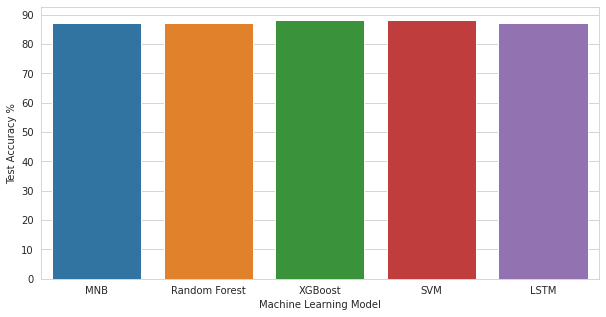

In [30]:
#Comapring the accuracy for various models

model = ['MNB', 'Random Forest', 'XGBoost', 'SVM', 'LSTM']
acc = [MNB_accuracy, rfc_accuracy, xgb_accuracy, svc_accuracy, LSTM_accuracy]

sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Test Accuracy %")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model, y= acc)
plt.show()

Since the data is imbalanced, f1-score is better evaluation metric when compared to accuracy scores for classification problems

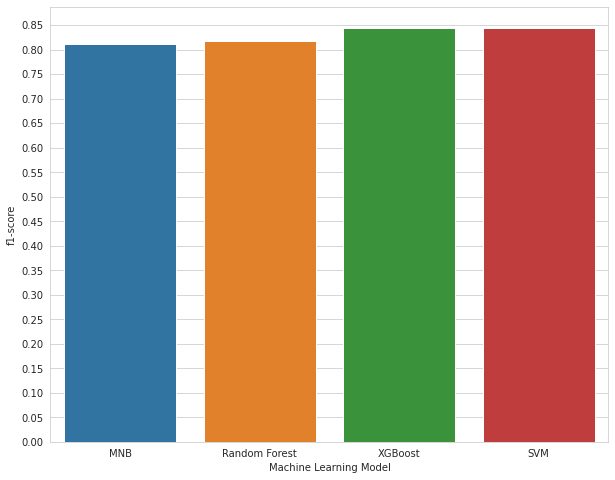

In [31]:
# Comparing the f1-score for various models
model = ['MNB', 'Random Forest', 'XGBoost', 'SVM']
f1_score = [MNB_f1, rfc_f1, xgb_f1, svc_f1]

sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
plt.yticks(np.linspace(0,1,21))
plt.ylabel("f1-score")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model,  y= f1_score)
plt.show()